In [1]:
"""
Convert building footprints to centroid and sample the image stack
"""

# Packages
import os, time, sys
from os.path import join
import geopandas as gpd
import pandas as pd
import rasterio as rio
import seaborn as sns
import gc

print(os.getcwd())
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/'

# Custom functions
sys.path.append(os.getcwd())
import __functions
from __functions import *

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Ready !!!")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/code
Ready !!!


In [2]:
# Sample the footprint data !!

In [3]:
# Reference data (footprints)
ref_fp = join(maindir, 'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
# Image data (see psscene-prep.ipynb)
stack_fp = join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
print(f'Reference file path: {ref_fp};\nImage file path: {stack_fp}')

Reference file path: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg;
Image file path: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif


In [4]:
t0 = time.time()

# Create the band stats class
band_stats_obj = BandStatistics(ref_fp, stack_fp, unique_id='uid')
# Run parallel band statistics computation
sampled = band_stats_obj.parallel_compute_stats(stat='mean')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Raster contains 7 bands: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI9x9', 'NISI27x27']
Using 7 workers.
Total elapsed time: 1.52 minutes.

~~~~~~~~~~



In [5]:
sampled.head(10)

,uid,nir,NDBIbg,NDBIrg,NISI,MNF1,NISI9x9,NISI27x27
0,1CS,-0.245692,0.372881,0.471780,0.203195,0.079622,2.243591,0.326121
1,2CS,-0.855340,0.631817,1.064319,1.000691,0.568533,0.353092,0.014427
2,3CS,-0.863371,0.812994,0.806018,0.734133,0.217392,-0.783993,-1.094286
3,4CS,-0.735319,0.304257,0.855749,0.507825,0.069417,0.406940,0.475877
4,5CS,-0.418197,0.515780,0.896718,0.447178,0.184560,-0.268841,-0.592085
5,6CS,-0.473975,-0.387343,0.116222,-0.230056,-0.458855,0.151583,-0.282302
6,7CS,-0.886402,0.472308,0.825466,0.672323,0.131482,0.405176,0.636150
7,8CS,-0.983113,1.293114,0.951977,1.334989,1.001782,-1.051071,0.563281
8,9CS,-0.121351,0.458495,0.640671,0.511772,0.517700,0.831786,-0.061723
9,10CS,-0.557708,0.440823,0.875362,0.466553,0.136942,0.003379,-0.521902


In [6]:
# Merge to the original dataframe
ref = gpd.read_file(ref_fp)
ref.columns

Index(['class_code', 'areaUTMsqft', 'uid', 'description', 'code', 'geometry'], dtype='object')

In [7]:
sampled = pd.merge(ref, sampled, on='uid', how='left')
sampled.columns

Index(['class_code', 'areaUTMsqft', 'uid', 'description', 'code', 'geometry',
       'nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI9x9', 'NISI27x27'],
      dtype='object')

In [8]:
gc.collect() # garbage cleanup

0

In [ ]:
# Save out the sampled data

In [11]:
# Write a csv with sampled data
out_fp = join(maindir,'data/tabular/mod/dc_data/training/dc_data_reference_footprint_sampled.csv')
sampled = sampled.drop('geometry', axis='columns', inplace=True)
sampled.to_csv(out_fp)
print(f'Saved sampled data table to {out_fp}')

Saved sampled data table to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/tabular/mod/dc_data/training/dc_data_reference_footprint_sampled.csv


In [ ]:
# Testing relationships ...

In [17]:
import scipy.stats as stats

# Assuming df is your DataFrame with columns 'class' and 'reflectance_band1'
classes = sampled_gdf['class_code'].unique()

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(*(sampled_gdf[sampled_gdf['class_code'] == cls]['NISI9x9'] for cls in classes))
f_value_, p_value_ = stats.f_oneway(*(sampled_gdf[sampled_gdf['class_code'] == cls]['NISI27x27'] for cls in classes))

print(f'ANOVA F-value (NISI9x9): {f_value}, p-value: {p_value}\nANOVA F-value (NISI27x27): {f_value_}, p-value: {p_value_}')

ANOVA F-value (NISI9x9): 636.1602910232137, p-value: 0.0
ANOVA F-value (NISI27x27): 162.35158642238838, p-value: 9.266652149444943e-206


### Spectral signature plot

['class_code' 'areaUTMsqft' 'uid' 'description' 'code' 'geometry' 'nir'
 'NDBIbg' 'NDBIrg' 'NISI' 'MNF1' 'NISI9x9' 'NISI27x27']
['Composition Shingle' 'Metal' 'Slate' 'Urethane' 'Tile'
 'Wood shake/shingle' 'Shingle']


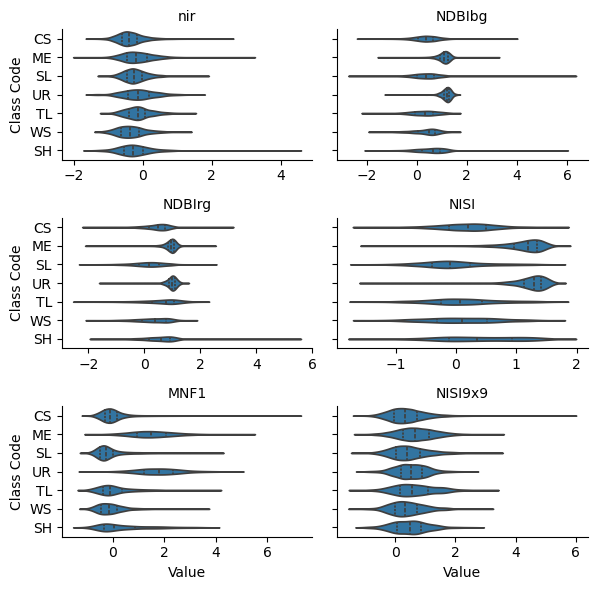

In [18]:
# Plot the distribution of abundances per material type by class
print(sampled_gdf.columns.values)
print(sampled_gdf['description'].unique())

new_cols = ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI9x9'] # removing the 27x27 texture

# Melt the DataFrame to long format
sampled_gdf_m = sampled_gdf.melt(
    id_vars=['class_code'],
    value_vars=new_cols,
    var_name='Band',
    value_name='Value')

# Create a facet plot
g = sns.catplot(data=sampled_gdf_m, x='Value', y='class_code', col='Band',
                kind='violin', sharey=True, sharex=False, inner='quartile', 
                col_wrap=2, height=2, aspect=1.5)

# Adjusting the titles and axis labels (if needed)
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Class Code")

# Save the plot


# Display the plot
plt.show()
